<center>
    <h1>Counting the number of triangles in an undirected graph using Apache Spark</h1>
    <h2>Elia Perantoni</h2>
</center>

<div style="height: 20px"></div>

This notebook is an implementation and analysis of the TTP (Triangle Type Partition) algorithm published in:
> Park, Ha-Myung, and Chin-Wan Chung. "An efficient mapreduce algorithm for counting triangles in a very large graph." Proceedings of the 22nd ACM international conference on Information & Knowledge Management. 2013.

After trying out the algorithm with the same example found in the paper, we also:
- Test it with larger datasets found in the [Standford Large Network Dataset Collection](http://snap.stanford.edu/data/index.html).
- Try different values of $\rho$ (explained later) to see how that affects the total running time and the size of the shuffle data.
- Compare it with GP (Graph Partition), the algorithm that the mentioned paper attempts to improve upon.

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

<center>
    <h2>Implementation</h2>
    <h3>Loading the dataset</h3>
</center>

For this first section, we're going to use the same simple graph found in the paper.

In [2]:
DATASET = "datasets/simple.txt"

Each line in the dataset is composed of a pair of node-IDs separated by whitespace.
We want to preprocess the dataset by filtering out empty lines, splitting the nodes, converting the IDs to integers and, finally, converting the resulting 2-list of IDs to a 2-tuple (this last step is just for personal preference).

In [3]:
edges = (sc
    .textFile(DATASET)
    .filter(bool)                     # Discard empty lines
    .map(lambda line: line.split())   # Split nodes in edge (one edge per line)
    .map(lambda x: list(map(int, x))) # Parse node ids
    .map(tuple))                      # Convert list to tuple

# Make sure the RDD is stored in RAM because it will be used by two separate map steps
edges.persist()

PythonRDD[2] at RDD at PythonRDD.scala:53

In [4]:
# Inspect edges
edges.take(5)

[(1, 2), (1, 3), (2, 3), (4, 5), (4, 6)]

Here's what the graph looks like:

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def display_graph(G, title=None, partfunc=lambda x: 0):
    # A color for each partition. If not partitioning function is provided,
    # then only the first color will be used.
    colormap = [
        "#1a46e8",
        "#0d8209",
        "#b30b37",
        "#ba7418",
    ]
    # Map list of nodes to colors, given the partition
    colors = [colormap[partfunc(node)] for node in G]
    
    nx.draw(G, nx.spring_layout(G, seed=1),
            with_labels=True,
            node_color=colors,
            font_color="white")
    plt.title(title)

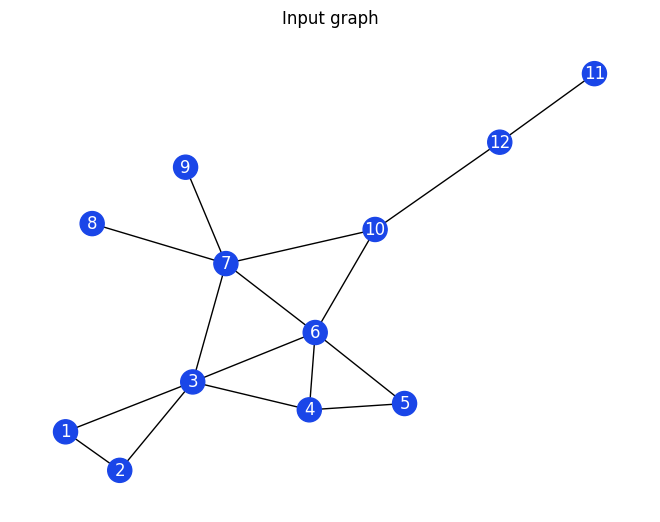

In [6]:
G = nx.from_edgelist(edges.collect())
display_graph(G, "Input graph")

<center>
    <h3>Partitioning</h3>
</center>

The algorithm works by splitting the graph in $\rho$ partitions. We set it to 4 for the time being to align with the example found in the paper.

We also need a partitioning function that will provide a way to assign each and every node to a partition. For now, we're using a simplified and non-ideal partitioning function that will produce the same partitions found in the paper's example. Later one, we will switch to a better one based on the modulo operator.

In [7]:
# Number of disjunct partitions to split the graph in.
RHO = 4

# Assigns a node to a partition such that every partition has roughly the same number of nodes.
def P(node: int) -> int:
    return (node - 1) // (RHO - 1)

Let's take a look at the graph, now that it has been partitioned.

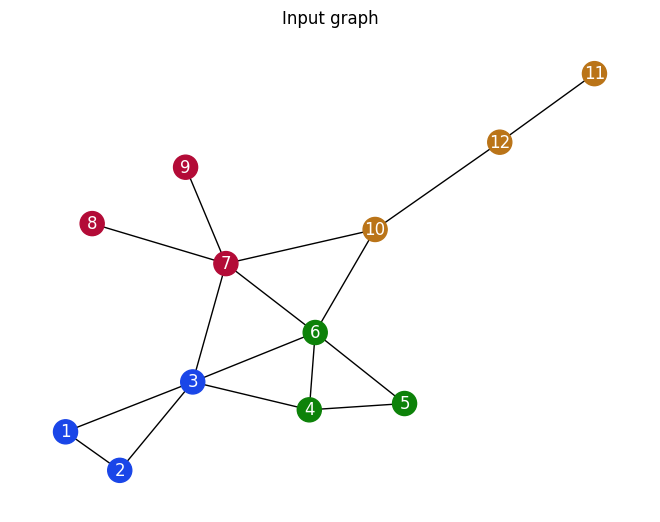

In [8]:
display_graph(G, "Input graph", partfunc=P)

The algorithm computes all possible 2-partitions from the initial graph. A 2-partition is a subgraph obtained by merging any 2 partitions.

If the initial graph is $G$, here's what $G_{01}$ and $G_{02}$ look like:

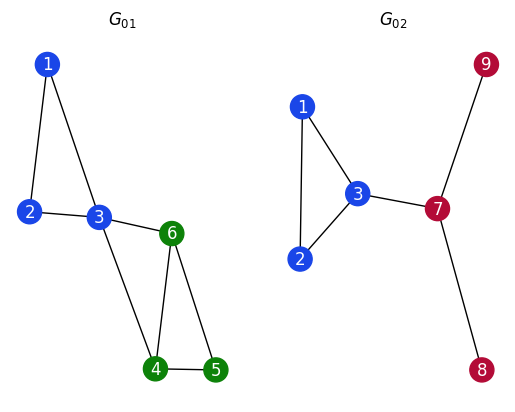

In [9]:
G01 = G.subgraph([node for node in G.nodes if P(node) in [0, 1]])
plt.subplot(121)
display_graph(G01, "$G_{01}$", partfunc=P)

G02 = G.subgraph([node for node in G.nodes if P(node) in [0, 2]])
plt.subplot(122)
display_graph(G02, "$G_{02}$", partfunc=P)

The algorithm also computes all possible 3'-partitions from the initial graph. The concept is basically the same (except 3 partitions are merged instead of 2) but, in addition, only outer-edges are retained. An outer edge is an edge $(u,v)$ that crosses a partition boundary: $P(u) \neq P(v)$. That's what the single quote in 3'-partition stands for.

Here's what $G_{012}$ looks like, note that almost all edges have been stripped out.

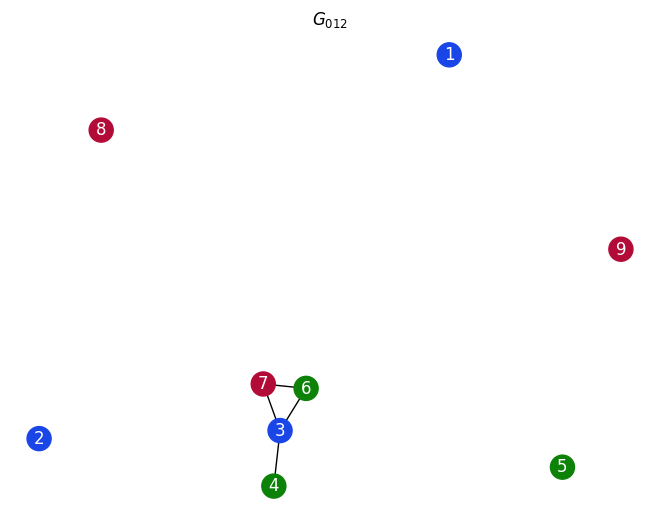

In [10]:
G012 = G.subgraph([node for node in G.nodes if P(node) in [0, 1, 2]])
G012 = nx.subgraph_view(G012, filter_edge=lambda a, b: P(a) != P(b))
display_graph(G012, "$G_{012}$", partfunc=P)

In the future, we might refer to 2-partitions and 3'-partitions using the term: "combinatorial partitions" for brevity. That's because they are all derived by combining multiple partitions from the initial graph.

The first map step consists in emitting all possible `(comb_partition, edge)` pairs where `edge` belongs to `comb_partition` and `comb_partition` is either $(a,b)$ (a 2-partition) or $(a,b,c)$ (a 3'-partition). $a,b,c \in [0, \rho)$

This is done by mapping on the edges and, for each edge, enumerating all possible 2-partitions and 3'-partitions and emitting the pair only if the edge is contained in the combinatorial-partition. 3'-partitions also have an additional guard that checks whether the edge is an outer one. Recall that 3'-partitions are only made up of outer edges.

The process just mentioned is split in two mapping functions: one deals with 2-partitions and the other with 3'-partitions.

In [11]:
# For a given edge, produces a list of pairs that assigns this edge to all the 2-partitions that it belongs to.
# That is: given an edge (u,v), a list [((a,b), (u,v))] will be produced.
def edges_in_2p_map(edge):
    u, v = edge
    res = []
    for a in range(0, RHO - 1):
        for b in range(a + 1, RHO):
            if P(u) in [a, b] and P(v) in [a, b]:
                res.append(((a, b), (u, v)))     
    return res

# For a given edge, produces a list of pairs that assigns this edge to all the 3'-partitions that it belongs to.
# That is: given an edge (u,v), a list [((a,b,c), (u,v))] will be produced.
# Note that when (u,v) is an inner edge (that is, it doesn't cross any partition boundary) the produced list
# is empty.
def edges_in_3p_map(edge):
    u, v = edge
    
    if P(u) == P(v):
        return []
    
    res = []
    for a in range(0, RHO - 2):
        for b in range(a + 1, RHO - 1):
            for c in range(b + 1, RHO):
                if P(u) in [a, b, c] and P(v) in [a, b, c]:
                    res.append(((a, b, c), (u, v)))
    return res

We run both functions in parallel and join the resulting list of pairs.

In [12]:
edges_in_2p = edges.flatMap(edges_in_2p_map)
edges_in_3p = edges.flatMap(edges_in_3p_map)

edges_in_Xp = edges_in_2p.union(edges_in_3p)

In [13]:
# Inspect edges_in_Xp
edges_in_Xp.take(5)

[((0, 1), (1, 2)),
 ((0, 2), (1, 2)),
 ((0, 3), (1, 2)),
 ((0, 1), (1, 3)),
 ((0, 2), (1, 3))]

We now want to get the list of edges that compose each combinatorial partition. 

Recall that `edges_in_Xp` now looks like:
```
[
    (comb_partition, edge),
    (comb_partition, edge),
    (comb_partition, edge),
    ...
]
```
where `comb_partition` may be repeated.

By performing a `groupByKey` we are merging all edges belonging to the same `comb_partition`, because that's the key in the RDD.

In [14]:
# Merge together all the edges belonging to the same partition
edges_in_Xp_merged = edges_in_Xp.groupByKey()

In [15]:
# Inspect edges_in_Xp_merged
edges_in_Xp_merged.take(5)

[((0, 2), <pyspark.resultiterable.ResultIterable at 0x7ff9efe11660>),
 ((0, 1, 2), <pyspark.resultiterable.ResultIterable at 0x7ff9efe12e30>),
 ((0, 2, 3), <pyspark.resultiterable.ResultIterable at 0x7ff9efe11e70>),
 ((0, 1), <pyspark.resultiterable.ResultIterable at 0x7ff9efe210c0>),
 ((1, 2), <pyspark.resultiterable.ResultIterable at 0x7ff9efe211e0>)]

<center>
    <h3>Assigning weights</h3>
</center>

We now have a list of `(comb_partition, edges)` pairs where `comb_partition` is either a 2-partition or a 3'-partition.

For each combinatorial partition, we need to enumerate the triangles in it and assign a weight to each. The sum of the weights of all triangles in all partitions will produce the final result; that is: the number of triangles in the initial graph $G$.

Some triangles are observed multiple times in different partitions. If a triangle $\Delta(u, v, x)$ for instance, is entirely contained in partition $G_i$, then it will be observed in all 2-partitions $G_{ij}$ with $j \in [0, \rho) \wedge j\neq i$.

Because of this, we need to classify triangles and assign different weights to each in order to contrast the duplication:
- Type I: A triangle entirely contained within a single partition
- Type II: A triangle entirely contained within 2 partitions
- Type III: A triangle spanning 3 partitions, with each of the 3 nodes belonging to a different one. The interesting thing about this type of triangle is that its edges are all outer. That's why we don't need inner edges in 3'-partitions.

Type III triangles are only observed once in the 3'-partition that they span, so we can assign a weight of 1 to them. Type II triangles are also observed once in the 2-partition that they span. They are not observed in 3'-partitions because Type II triangles have at least one inner edge, which 3'-partitions always lack. So we can also assign a weight of 1 to them.

A Type I triangle included in partition $G_i$ is observed in every 2-partition $G_{ij}$ where $j \in [0, \rho) \wedge j\neq i$. Since there are $\rho-1$ partitions to choose from for $j$, we need to use a weight such that $\rho-1$ of it sum to 1. That's $\frac{1}{\rho-1}$.

---

We're using fractions instead of floating point numbers to represent the weights because, otherwise, small errors would creep up and accumulate over time, potentially leading to a wrong end result. Storing fractions as two separate integers (numerator and denominator) is much safer.

---

For enumerating the triangles in a partition, any internal memory algorithm can be used. Because this whole algorithm deals with a list of edges, the edge-iterator algorithm seemed a good fit.

Note that the list of edges needs to be first inspected to produce an adjacency list for the edge-iterator algorithm to work.

In [16]:
# Will be used later on to avoid floating point arithmetic errors.
from fractions import Fraction

def assign_weight(triangle):
    u, v, x = triangle
    if P(u) == P(v) == P(x):
        # If triangle is Type I, then the weight is 1/(RHO-1).
        return Fraction(1, RHO-1)
    else:
        # For all other triangles, use 1 because they are observed only once.
        return Fraction(1, 1)

def total_partition_weight(edges):
    # Given the list of edges, build an adjacency list.
    adj = dict()
    for edge in edges:
        u, v = edge
        adj[u] = adj.get(u, set()) | {v}
        adj[v] = adj.get(v, set()) | {u}
        
    # Collect here the set of edges found in this partition.
    # Use a set to avoid duplication.
    triangles = set()
    for edge in edges:
        u, v = edge
        # Take the intersection of the adjacency list of u and v.
        # For each node x, a triangle (u,v,x) exists.
        triangles |= {frozenset((u,v,x)) for x in adj[u] & adj[v]}
    
    # For each triangle found in this partition, compute its weight.
    _sum = Fraction(0, 1)
    for triangle in triangles:
        _sum += assign_weight(triangle)
        
    # And return the sum of the weights.
    return _sum

Apply the step described above to all partitions.

Note that the `comb_partition` part in each `(comb_partition, edges)` pair is discarded because that's not really needed for the triangle enumeration algorithm or the weight computation to work. It was only need to group up all edges belonging to the same combinatorial partition.

In [17]:
weights = (edges_in_Xp_merged
    .map(lambda x: x[1])          # Discard the partition's info as we don't actually need that
    .map(total_partition_weight)) # For each partition, compute the sum of the triangles' weight

In [18]:
# Inspect weights
weights.take(5)

[Fraction(1, 3),
 Fraction(1, 1),
 Fraction(0, 1),
 Fraction(5, 3),
 Fraction(1, 3)]

Finally, sum the weights coming from each partition to get our final result.

In [19]:
# Sum the weight from every partition
round(weights.sum())

5

That's what we expected! (See the example in the paper)

Let's now bundle the whole process inside a function to make further analysis and testing easier and use a better hashing function (recall that the previous function was only to replicate the example found in the paper).

In [20]:
# A function wrapping all of the above
def count_triangles(dataset):
    _edges = (sc
        .textFile(dataset)
        .filter(bool)                     # Discard empty lines
        .map(lambda line: line.split())   # Split nodes in edge (one edge per line)
        .map(lambda x: list(map(int, x))) # Parse node ids
        .map(tuple))
    
    _edges_in_2p = _edges.flatMap(edges_in_2p_map)
    _edges_in_3p = _edges.flatMap(edges_in_3p_map)

    _edges_in_Xp = _edges_in_2p.union(_edges_in_3p)
    
    # Merge together all the edges belonging to the same partition
    _edges_in_Xp_merged = _edges_in_Xp.groupByKey()
    
    _weights = (_edges_in_Xp_merged
        .map(lambda x: x[1])          # Discard the partition's info as we don't actually need that
        .map(total_partition_weight)) # For each partition, compute the sum of the triangles' weight
    
    return round(_weights.sum())

# A better partitioning function
def P(node: int) -> int:
    return node % RHO

<center>
    <h2>Testing</h2>
</center>

Let's now test the algorithm against a number of datasets to see if it produces the correct result. The first test case is the one that we've already covered and is the same found in the paper that this notebook is based on; while the others are taken from the [Standford Large Network Datase Collection](http://snap.stanford.edu/data/index.html).

For each test case we give its name, path on the filesystem and the number of triangles that we expect to get back.

In [21]:
tests = [
    {"name": "Simple", "path": "datasets/simple.txt", "expected": 5},
    {"name": "EgoFacebook", "path": "datasets/ego_facebook.txt", "expected": 1612010},
    {"name": "Enron", "path": "datasets/enron.txt", "expected": 727044},
    {"name": "Amazon", "path": "datasets/amazon.txt", "expected": 667129},
    {"name": "California road network", "path": "datasets/ca_roads.txt", "expected": 120676},
]

for test in tests:
    print(f"Now testing with dataset {test['name']}")
    got = count_triangles(test['path'])
    print(f"Expected: {test['expected']}\nGot:      {got}")
    if got == test["expected"]:
        print("OK")
    else:
        print("BAD")
    print()

Now testing with dataset Simple
Expected: 5
Got:      5
OK

Now testing with dataset EgoFacebook


Expected: 1612010
Got:      1612010
OK

Now testing with dataset Enron


Expected: 727044
Got:      727044
OK

Now testing with dataset Amazon


Expected: 667129
Got:      667129
OK

Now testing with dataset California road network


Expected: 120676
Got:      120676
OK



<center>
    <h2>Impact of $\rho$</h2>
</center>

$\rho$, the number of partitions that give rise to 2-partitions and 3'-partitions, greatly influences how the work is distributed among workers. A smaller $\rho$ will result in a smaller number of combinatorial partitions but it also makes each of those partitions larger. Recall that the TTD algorithm requires a single combinatorial partition to fit in internal memory, so that an auxiliary algorithm can enumerate its triangles and assign a weight to each.

Let's try running the algorithm on the Ego Facebook dataset with different values of $\rho$ to see how that impacts the execution time and the amount of shuffled data exchanged between the `groupBykey` step, that builds the combinatorial partitions, and the application of the internal memory algorithm to each.

---

But first, we define some utility functions that will scrape the Spark admin interface to read the size of shuffled data in bytes, as there's no way to fetch that information from the `PySparkContext`.

In [22]:
import requests
from bs4 import BeautifulSoup
from humanfriendly import parse_size

def latest_job_id():
    soup = BeautifulSoup(requests.get(sc.uiWebUrl + "/jobs").text, "html.parser")
    td = soup.find(id="completedJob-table").tbody.tr.td
    return td.text.strip()

def get_shuffle_bytes(job_id):
    soup = BeautifulSoup(requests.get(sc.uiWebUrl + f"/jobs/job/?id={job_id}").text, "html.parser")
    header = soup.find(id="completedStage-table").thead.tr.contents
    i = next(i for i, stage in enumerate(header) if stage.find(text=lambda t: "Shuffle Write" in t))
    
    for row in soup.find(id="completedStage-table").tbody.find_all("tr"):
        b = row.find_all("td")[i].text.strip()
        if b:
            return parse_size(b)

For the actual execution with different values of $\rho$:

In [23]:
from timeit import default_timer as timer

test = next(test for test in tests if test["name"] == "EgoFacebook")

rhos = []
times = []
shuffle_bytes = []

# Warm up the RDD read from file to as not not penalize the first rho value
count_triangles(test["path"])

for try_this_rho in range(2, 16 + 1):
    RHO = try_this_rho
    
    start = timer()
    assert count_triangles(test["path"]) == test["expected"]
    end = timer()
    
    rhos.append(try_this_rho)
    times.append(end - start)
    shuffle_bytes.append(get_shuffle_bytes(latest_job_id()))
    
# Restore old rho
RHO = 4

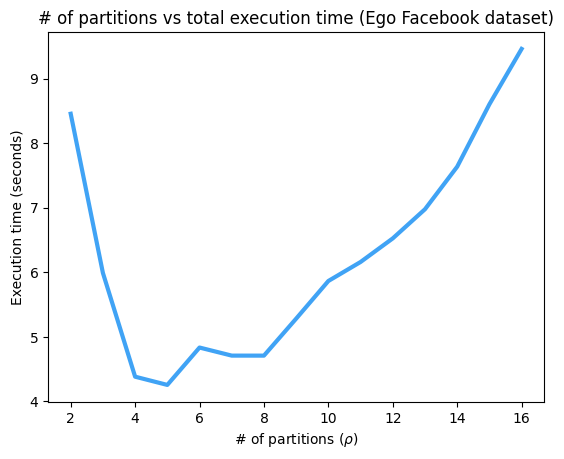

In [24]:
fig1 = plt.figure()
plt.plot(rhos, times, c="#40a3f5", linewidth=3)
plt.title("# of partitions vs total execution time (Ego Facebook dataset)")
plt.xlabel("# of partitions ($\\rho$)")
plt.ylabel("Execution time (seconds)")
plt.savefig("img/rho_time.png", dpi=400)

On my machine and with the chosen dataset, $\rho=4$ or $\rho=5$ seems to be the best possible choice if one prioritizes lower execution times.

Higher values result in more data duplication, as we will soon see. While lower values (2 and 3) make combinatorial partitions larger; putting more stress on the internal memory algorithm and driving up its computational cost. It's a tradeoff between the computational complexity of the outer TTP algorithm and the internal memory one.

Not only that, lower values of $\rho$ mean that more and more triangles become Type I or Type II instead of Type III. This comes as a disadvantage because Type III triangles can be found in 3'-partitions which have been stripped down of every edge expect outer ones and are thus "lighter".

---

Let's now take a look at the size of shuffled data:

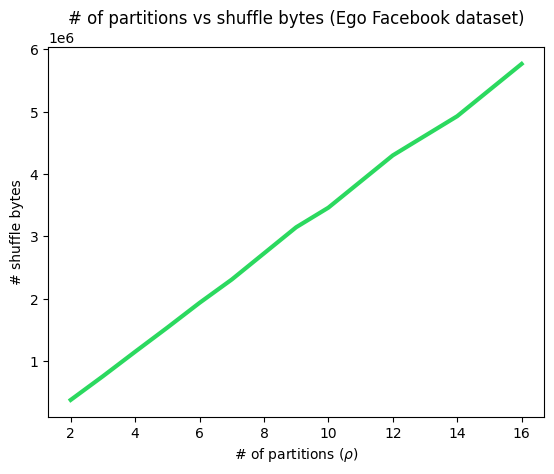

In [25]:
fig2 = plt.figure()
plt.plot(rhos, shuffle_bytes, c="#2bd95f", linewidth=3)
plt.title("# of partitions vs shuffle bytes (Ego Facebook dataset)")
plt.xlabel("# of partitions ($\\rho$)")
plt.ylabel("# shuffle bytes")
plt.savefig("img/rho_data.png", dpi=400)

As expected, the amount of bytes shuffled increases as $\rho$ increases. That's because there are more combinatorial partitions.

With more values of $i,j,k \in [0, \rho)$ to choose from, there are more $G_{ij}$ and $G_{ijk}$ combinations. In fact, the total number of combinatorial partitions is: ${\rho \choose 2} + {\rho \choose 3}$.

Let's take a look at that in the next plot:

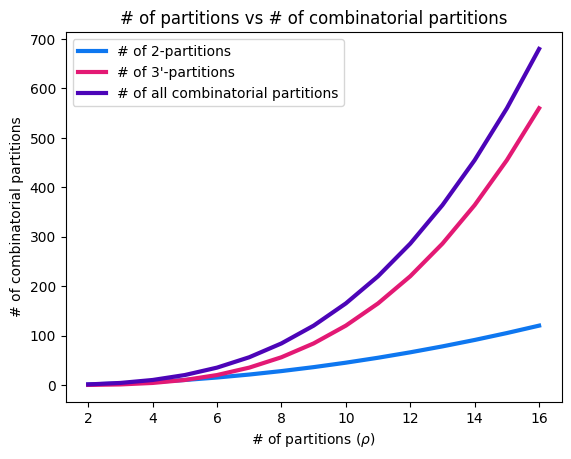

In [26]:
import scipy.special
combinatorial_2 = [scipy.special.comb(rho, 2) for rho in rhos]
combinatorial_3 = [scipy.special.comb(rho, 3) for rho in rhos]
combinatorial_all = [scipy.special.comb(rho, 2) + scipy.special.comb(rho, 3) for rho in rhos]

fig3 = plt.figure()

plt.plot(rhos, combinatorial_2, c="#0e77f0", linewidth=3, label="# of 2-partitions")
plt.plot(rhos, combinatorial_3, c="#e31974", linewidth=3, label="# of 3'-partitions")
plt.plot(rhos, combinatorial_all, c="#4c04b8", linewidth=3, label="# of all combinatorial partitions")

plt.title("# of partitions vs # of combinatorial partitions")
plt.xlabel("# of partitions ($\\rho$)")
plt.ylabel("# of combinatorial partitions")
plt.legend()

plt.savefig("img/rho_comb.png", dpi=400)

All in all, it seems like one should prefer lower values of $\rho$. Possibly, the lowest that one can afford before a single combinatorial partion can no longer fit in memory. But beware of the computational complexity of the internal memory algorithm: a slightly higher value or $\rho$ might be a better tradeoff.

<center>
    <h2>Comparison with GP algorithm</h2>
</center>

The TTP algorithm published in the paper and implemented in this notebook is based upon, and attempts to improve, the GP (Graph Partition) algorithm.

In contrast with TTP, it only works with 3-partitions (note the absence of the single quote, inner edges are preserved). It used the same process of enumerating the edges in each combinatorial partition (now just 3-partitions) and assigning weights to each in such a way that triangles observed multiple times sum to 1.

The main critique on GP, that inspired the authors to develop TTP, is that 3-partitions contain a lot of duplicate edges. TTP utilizes the fact that Type III triangles can be correctly counted without inner edges to reduce this duplication.

Here's the GP algorithm implemented in a function for future analysis:

In [27]:
import scipy.special

def count_triangles_gp(dataset):
    _edges = (sc
        .textFile(dataset)
        .filter(bool)                     # Discard empty lines
        .map(lambda line: line.split())   # Split nodes in edge (one edge per line)
        .map(lambda x: list(map(int, x))) # Parse node ids
        .map(tuple))
    
    def edges_in_3p_gp_map(edge):
        u, v = edge

        res = []
        for a in range(0, RHO - 2):
            for b in range(a + 1, RHO - 1):
                for c in range(b + 1, RHO):
                    if P(u) in [a, b, c] and P(v) in [a, b, c]:
                        res.append(((a, b, c), (u, v)))
        return res
    
    _edges_in_3p = _edges.flatMap(edges_in_3p_gp_map)
    
    # Merge together all the edges belonging to the same partition
    _edges_in_Xp_merged = _edges_in_3p.groupByKey()
    
    # Precompute this because it's kind of slow to do
    weight_type_1 = int(scipy.special.comb(RHO-1, 2))
    
    def assign_weight_gp(triangle):
        u, v, x = triangle
        n_distinct_partitions = len({P(u), P(v), P(x)})
        if n_distinct_partitions == 3:
            return Fraction(1, 1)
        elif n_distinct_partitions == 2:
            return Fraction(1, RHO-2)
        else:
            return Fraction(1, weight_type_1)
    
    def total_partition_weight_gp(edges):
        # Given the list of edges, build an adjacency list
        adj = dict()
        for edge in edges:
            u, v = edge
            adj[u] = adj.get(u, set()) | {v}
            adj[v] = adj.get(v, set()) | {u}

        # Collect here the set of edges found in this partition
        triangles = set()
        for edge in edges:
            u, v = edge
            triangles |= {frozenset((u,v,x)) for x in adj[u] & adj[v]}

        # For each triangle found in this partition, compute its weight
        _sum = Fraction(0, 1)
        for triangle in triangles:
            _sum += assign_weight_gp(triangle)

        # And return the sum of the weights
        return _sum
    
    _weights = (_edges_in_Xp_merged
        .map(lambda x: x[1])             # Discard the partition's info as we don't actually need that
        .map(total_partition_weight_gp)) # For each partition, compute the sum of the triangles' weight
    
    return round(_weights.sum())

Let's now run both TTP and GP on the Ego Facebook dataset with different values of $\rho$ to compare execution time and size of shuffled data.

In [28]:
test = next(test for test in tests if test["name"] == "EgoFacebook")

rhos = []

times_ttp = []
shuffle_bytes_ttp = []

times_gp = []
shuffle_bytes_gp = []

# Warm up the RDD read from file to as not not penalize the first rho value
count_triangles(test["path"])

for try_this_rho in range(3, 16 + 1):
    RHO = try_this_rho
    rhos.append(try_this_rho)
    
    # TTP ------------------------------
    
    start = timer()
    assert count_triangles(test["path"]) == test["expected"]
    end = timer()
    
    times_ttp.append(end - start)
    shuffle_bytes_ttp.append(get_shuffle_bytes(latest_job_id()))
    
    # GP -------------------------------
    
    start = timer()
    assert count_triangles_gp(test["path"]) == test["expected"]
    end = timer()
    
    times_gp.append(end - start)
    shuffle_bytes_gp.append(get_shuffle_bytes(latest_job_id()))
    
# Restore old rho
RHO = 4

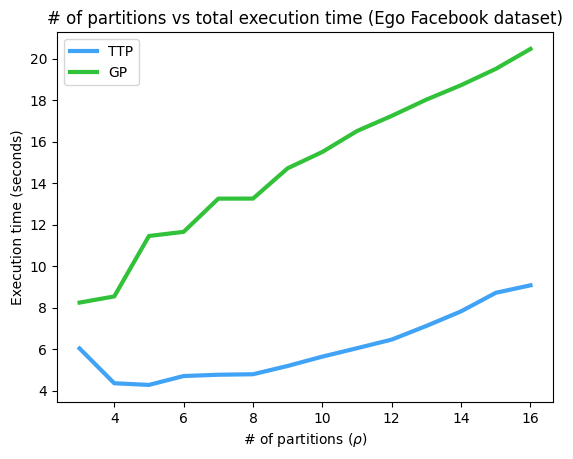

In [29]:
fig4 = plt.figure()
plt.plot(rhos, times_ttp, c="#40a3f5", linewidth=3, label="TTP")
plt.plot(rhos, times_gp, c="#32c23a", linewidth=3, label="GP")
plt.title("# of partitions vs total execution time (Ego Facebook dataset)")
plt.xlabel("# of partitions ($\\rho$)")
plt.ylabel("Execution time (seconds)")
plt.legend()
plt.savefig("img/vs_gp_time.png", dpi=400)

As we can see, TTP consistently performs better than GP. Supporting the thesis of the paper.

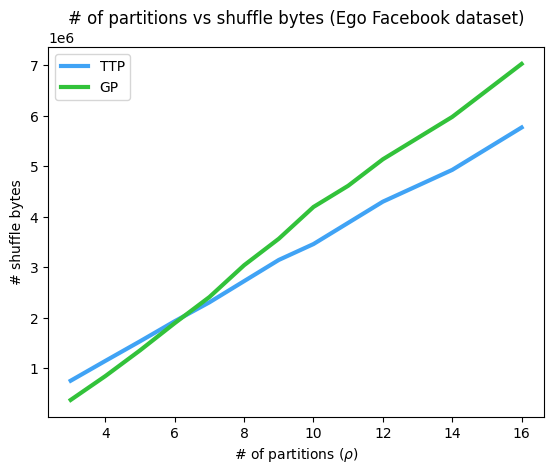

In [30]:
fig5 = plt.figure()
plt.plot(rhos, shuffle_bytes_ttp, c="#40a3f5", linewidth=3, label="TTP")
plt.plot(rhos, shuffle_bytes_gp, c="#32c23a", linewidth=3, label="GP")
plt.title("# of partitions vs shuffle bytes (Ego Facebook dataset)")
plt.xlabel("# of partitions ($\\rho$)")
plt.ylabel("# shuffle bytes")
plt.legend()
plt.savefig("img/vs_gp_data.png", dpi=400)

Except for smaller values of $\rho$, TTP achieves its goal of reducing duplicate data.

For a lower number of partitions, GP uses less data because all types of triangles are counted on 3-partitions alone while TTP makes a distinction, working on both 2-partitions and 3'-partitions. The efficiency gain of that only emerges when one works with a larger number of partitions, which is expected anyway when working with large graphs.